# ML Road Segmentation

# Library and functions loading

In [2]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image
import scipy
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D, LSTM, Merge
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.core import Reshape
from function import *
from mask_to_submission import *

Using TensorFlow backend.


# Image loading

In [3]:
# image
image_dir = "data/training/images/"
files = os.listdir(image_dir)
n = min(100, len(files)) # Load maximum 100 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

pad = 4

# Image are zero padded with 4 pixels at each sides
print("Loading " + str(n) + " images_padded")
imgs_padded = [np.pad(load_image(image_dir + files[i]), ((pad,pad),(pad,pad),(0,0)), 'constant') for i in range(n)]
print(files[0])

# groundtruth
gt_dir = "data/training/groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])

n = 100 # Only use 100 images for training

Loading 100 images
satImage_001.png
Loading 100 images_padded
satImage_001.png
Loading 100 images
satImage_001.png


In [4]:
# Here we display the shape of the padded images
imgs_padded[0].shape

(408, 408, 3)

### Image size

In [5]:
print('Image size = ' + str(imgs[0].shape))
print('Image type', type(imgs[0]))

Image size = (400, 400, 3)
Image type <class 'numpy.ndarray'>


### Visualize image and its groundtruth

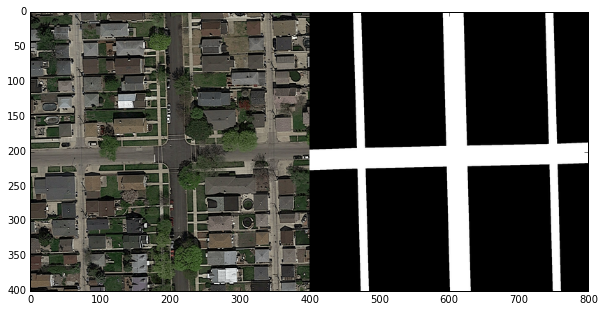

In [6]:
cimg = concatenate_images(imgs[0], gt_imgs[0])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')

# Processing

### Extract patches from input images

In [7]:
patch_size = 16 # each patch is 16*16 pixels

img_patches = [img_crop_padded(imgs_padded[i], patch_size, patch_size, pad) for i in range(n)]
gt_patches = [img_crop_output(gt_imgs[i], patch_size, patch_size) for i in range(n)]

print(np.array(img_patches).shape)

(100, 625, 24, 24, 3)


### Linearize list of patches

In [8]:
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

print('Size patch image', img_patches.shape)
print('Size patch groundtruth', gt_patches.shape)

Size patch image (62500, 24, 24, 3)
Size patch groundtruth (62500, 256)


### Training samples

In [9]:
# The training samples are simply the patches of the original images linearized
X_train = img_patches

# Computation of the binary value for the labels of the ground.
Y_train = gt_patches

# Neural network model

- Convolution2D : Convolution operator for filtering windows of two-dimensional inputs
- ZeroPadding2D : pad the input volume with zeros around the border, allow to control the spatial size of the output volumes 
- MaxPooling2D : progressively reduce the spatial size of the representation to reduce the amount of parameters and computation in the network, and hence to also control overfitting.
- Flatten : converts the 3D feature maps to 1D feature vectors
- Dense : fully connected layer, Neurons have full connections to all activations in the previous layer
- Dropout: randomly setting a fraction p of input units to 0 at each update during training time, which helps prevent overfitting

border_mode = 'same' -> output has the same size as the input (zero-padding)

#### CNN

Here is the implementation of the first CNN model with keras

In [10]:
model_cnn = Sequential()
model_cnn.add(Convolution2D(32, 3, 3, activation='relu', border_mode='same', input_shape=(24, 24, 3)))
model_cnn.add(Convolution2D(32, 3, 3, activation='relu', border_mode='same'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Dropout(0.25)) 

model_cnn.add(Convolution2D(64, 3, 3, activation='relu', border_mode='same'))
model_cnn.add(Convolution2D(64, 3, 3, activation='relu', border_mode='same'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Dropout(0.25))

model_cnn.add(Convolution2D(128, 3, 3, activation='relu', border_mode='same'))
model_cnn.add(Convolution2D(128, 3, 3, activation='relu', border_mode='same'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Dropout(0.25))

model_cnn.add(Flatten())
#model_cnn.add(Dense(1024, activation='relu')) 
#model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(1024, activation='relu'))
model_cnn.add(Dropout(0.5))

#### CNN


Here is the implementation of the second CNN model with keras

In [11]:
model_cnn2 = Sequential()
model_cnn2.add(Convolution2D(32, 3, 3, activation='relu', border_mode='same', input_shape=(24, 24, 3)))
model_cnn2.add(Convolution2D(32, 3, 3, activation='relu', border_mode='same'))
model_cnn2.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn2.add(Dropout(0.25)) 

model_cnn2.add(Convolution2D(64, 3, 3, activation='relu', border_mode='same'))
model_cnn2.add(Convolution2D(64, 3, 3, activation='relu', border_mode='same'))
model_cnn2.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn2.add(Dropout(0.25))

model_cnn2.add(Flatten())
model_cnn2.add(Dense(1024, activation='relu'))
model_cnn2.add(Dropout(0.5))

#### Merge

In [12]:
merged = Merge([model_cnn, model_cnn2], mode='ave')

final_model = Sequential()
final_model.add(merged)
final_model.add(Dense(256, activation='sigmoid'))

### Compilation of the model

In [13]:

# Definition of a stochastic gradient optimizer in the keras framework
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
final_model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])

### Fitting the model to the training samples

In [14]:
# The weight are already saved. No need to run unless you want to test expressively
# (minimum 10 hours running though ^^)

#final_model.fit([X_train, X_train], Y_train, batch_size=32, nb_epoch=80)

Epoch 1/80
62500/62500 [==============================] - 671s - loss: 0.1362 - acc: 0.0050   
Epoch 2/80
62500/62500 [==============================] - 652s - loss: 0.1191 - acc: 0.0058   
Epoch 3/80
62500/62500 [==============================] - 634s - loss: 0.1122 - acc: 0.0094   
Epoch 4/80
62500/62500 [==============================] - 672s - loss: 0.1029 - acc: 0.0107   
Epoch 5/80
62500/62500 [==============================] - 680s - loss: 0.0959 - acc: 0.0142   
Epoch 6/80
62500/62500 [==============================] - 1460s - loss: 0.0902 - acc: 0.0158  
Epoch 7/80
62500/62500 [==============================] - 862s - loss: 0.0850 - acc: 0.0178   
Epoch 8/80
62500/62500 [==============================] - 594s - loss: 0.0814 - acc: 0.0168   
Epoch 9/80
62500/62500 [==============================] - 595s - loss: 0.0786 - acc: 0.0183   
Epoch 10/80
62500/62500 [==============================] - 596s - loss: 0.0756 - acc: 0.0223   
Epoch 11/80
62500/62500 [========================

#### Print a summary representation of your model

In [15]:
final_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 24, 24, 32)    896                                          
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 24, 24, 32)    9248                                         
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 12, 12, 32)    0                                            
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 12, 12, 32)    0                                            
___________________________________________________________________________________________

#### Save weights of the model

In [16]:
#final_model.save_weights("model_mergeCNN_final.h5")

#### Loading the model

In [13]:
# Here is we load the previously saved weigths of the model

final_model.load_weights("model_mergeCNN_final.h5")

# Testing on 1 image

In [14]:
# Image selected to be displayed (arbitrary choice)
img_idx = 54

print('pad size :', pad)


X_test = np.asarray(img_crop_padded(imgs_padded[img_idx], patch_size, patch_size, pad))

print('Size test sample :',X_test.shape)

pad size : 4
Size test sample : (625, 24, 24, 3)


### Prediction of the patch labels for the test samples

In [15]:
prediction = final_model.predict([X_test, X_test], batch_size=32)

In [16]:
print('size prediction', prediction.shape)
pred = np.array(prediction)
print('nb of prediction', len(pred))

size prediction (625, 256)
nb of prediction 625


### Binarization and reshaping of the prediction

In [17]:
# come from a sigmoid activation)
# We simply thresold each values

predict_binary = np.where(prediction > 0.5, 1, 0)

### Reshaping

In [18]:
im_test = deflatten(predict_binary, patch_size)
im_non_flat = np.asarray(im_test)

print('size unflatten prediction', im_non_flat.shape)

size unflatten prediction (625, 16, 16)


### Display prediction as an image

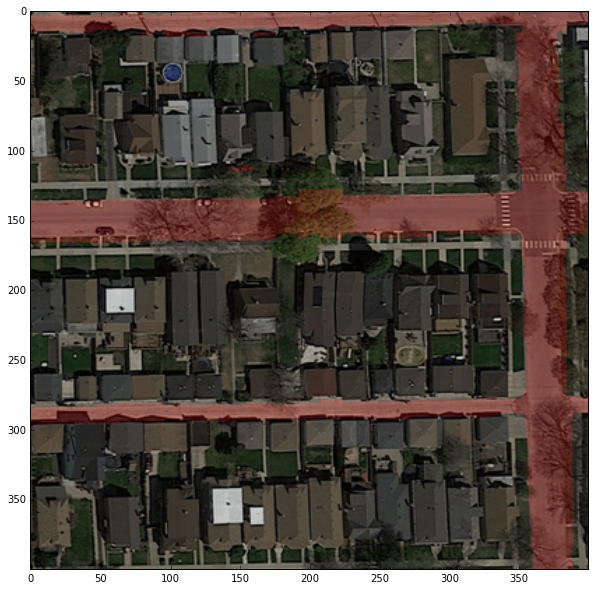

In [20]:
w = imgs[img_idx].shape[0]
h = imgs[img_idx].shape[1]
predicted_im = label_to_img(w, h, patch_size, patch_size, im_non_flat)

new_img = make_img_overlay(imgs[img_idx], predicted_im)

fig1 = plt.figure(figsize=(10, 10))
plt.imshow(new_img)

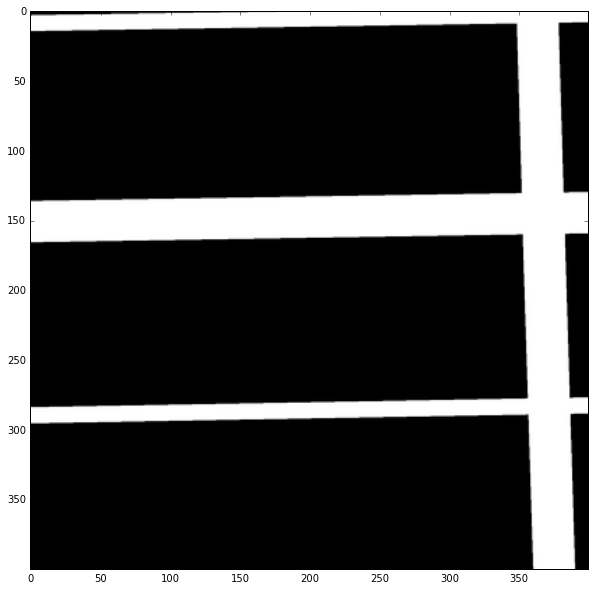

In [19]:
# The real groundTruth image is displayed for comparison

fig1 = plt.figure(figsize=(10, 10))
plt.imshow(gt_imgs[img_idx], cmap='Greys_r')

# Build submission on new images

### Loading test images

In [33]:
image_filenames = []
for i in range(1, 51):
    image_filename = 'data/test/test_%d' % i + '/test_%d' % i + '.png'
    image_filenames.append(image_filename)
    
images_test = [np.pad(load_image(image_filename), ((pad,pad),(pad,pad),(0,0)), 'constant') 
               for image_filename in image_filenames]

In [34]:
# Setting of the right width and height

w = images_test[0].shape[0] - 2*pad
h = images_test[0].shape[1] - 2*pad

### Save prediction as png in folder

In [ ]:
for i in range(0, 50):
    
    # format the image for the neural net
    X_test = np.asarray(img_crop_padded(images_test[i], patch_size, patch_size, pad))
    
    # Make the prediction
    prediction = final_model.predict([X_test, X_test], batch_size=32)

    # binarization of the output
    predict_binary = np.where(prediction > 0.5, 1, 0)

    # Reformation of the linear output into patch of (16,16)
    im_test = deflatten(predict_binary, patch_size)
    # Transform into array
    im_non_flat = np.asarray(im_test)
    
    # Transform the patches into a complete black and white image
    predicted_im = label_to_img(w, h, patch_size, patch_size, im_non_flat)
    
    j = i + 1
    # Save each image into a folder prediction 
    scipy.misc.imsave('prediction/resultImage_' + '%.3d' % j + '.png', predicted_im)

### Create submit.csv

In [26]:

submission_filename = 'data/submission.csv'
image_filenames = []
for i in range(1, 51):
    image_filename = 'prediction/resultImage_' + '%.3d' % i + '.png'
    image_filenames.append(image_filename)
    
#print(len(image_filenames))
masks_to_submission(submission_filename, *image_filenames)